# Detection d'object en Tensorflow

## Importation des packages

In [52]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import os
from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,MaxPool2D, BatchNormalization, Dropout
print(f'La version Tensorflow est : {tf.__version__}')

La version Tensorflow est : 2.8.0


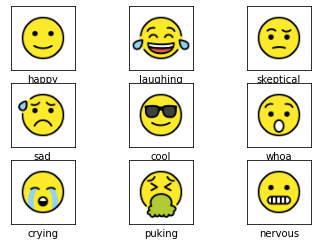

In [2]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i+1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Task 3: Create Examples

In [3]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [4]:
emojis[0]

{'name': 'happy',
 'file': '1F642.png',
 'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x27367DC9550>}

In [5]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    
    return image.astype('uint8'), class_id, (row + 10)/144, (col + 10)/144

In [6]:
image, class_id, row, col = create_example()

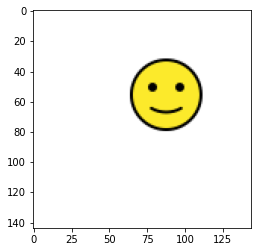

In [7]:
plt.imshow(image)

## Task 4: Bounding Boxes

In [8]:
def plot_bounding_box(image, gt_coords, pred_coords=None, norm=False):
    if norm:
        image *= 255
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    
    row, col = gt_coords
    row *= 144
    col *= 144
    
    draw.rectangle((col, row, col+52, row+52), outline='green', width=3)
    
    if pred_coords:
        row, col = gt_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col+52, row+52), outline='red', width=3)
    return image
        

In [9]:
images = plot_bounding_box(image, gt_coords=[row, col])

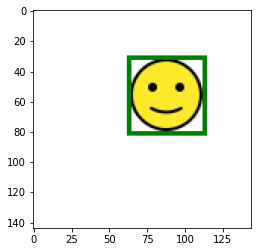

In [10]:
plt.imshow(images)

## Task 5: Data Generator

In [29]:
def data_generator(batch_size=16):
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))
    y_batch = np.zeros((batch_size, 9))
    bbox_batch = np.zeros((batch_size, 2))

    for i in range(0, batch_size):
      image, class_id, row, col = create_example()
      x_batch[i] = image / 255.
      y_batch[i, class_id] = 1.0
      bbox_batch[i] = np.array([row, col])
    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

Text(0.5, 1.0, 'laughing')

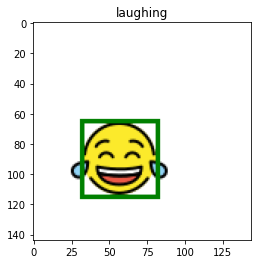

In [47]:
example, label = next(data_generator(2))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)

plt.imshow(image)
plt.title(emojis[class_id]['name'])

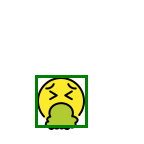

In [42]:
image

## Task 6: Model

In [73]:
# input_ = Input(shape=(144, 144, 3), name='image')
input_ = Input(shape=(144, 144, 3), name='image')
x = input_

for i in range(0, 5):
    n_filter = 2**(4+i)
    x = Conv2D(n_filter, 3, activation=tf.nn.relu)(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)
x = Flatten()(x)
x = Dense(256, activation=tf.nn.relu)(x)

class_out = class_out = Dense(9, activation=tf.nn.softmax, name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_68 (Conv2D)             (None, 142, 142, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_63 (BatchN  (None, 142, 142, 16  64         ['conv2d_68[0][0]']              
 ormalization)                  )                                                           